In [83]:
pip install -q pyyaml h5py

In [84]:
#tensorflow ver 2.0 ++ 여야 가능
#2.2 사용했다고 함
%tensorflow_version 2.x%

import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x%`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.



#1. Network 불러오기
###cv2.dnn.readNet(model, config=None, framework=None) -> retval

• model: 훈련된 가중치를 저장하고 있는 이진 파일 이름

• config: 네트워크 구성을 저장하고 있는 텍스트 파일 이름, config가 없는 경우도 많습니다.

• framework: 명시적인 딥러닝 프레임워크 이름

• retval: cv2.dnn_Net 클래스 객체

|딥러닝 프레임워크|model 파일 확장자|config 파일 확장자|framework 문자열|
|:---:|:---:|:---:|:---:|
|카페|*.caffemodel|*.prototxt|"caffe"|
|텐서플로우|*.pb|*.pbtxt|"tensorflow"|
|토치|*.t7 또는*.net||"torch"|
|다크넷|*.weights|*.cfg|"darknet"|
|DLDT|*.bin|*.xml|"dldt"|
|ONNX|*.onnx||"onnx"|


In [85]:
#모델 2개 load

facenet = cv2.dnn.readNet('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')
model = load_model('mask_detector.model') #keras model

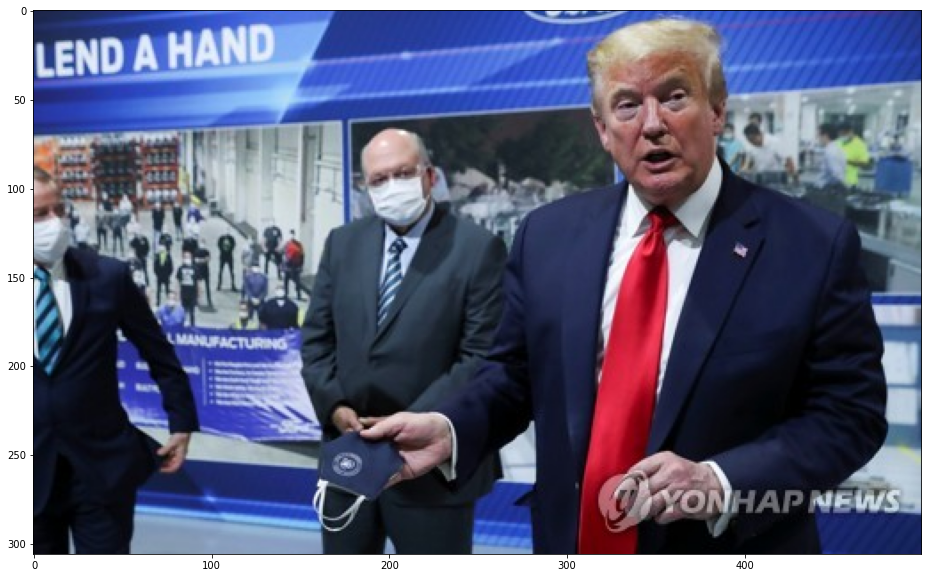

In [108]:
#test 할 img load
img = cv2.imread('02.jpg')
h, w = img.shape[:2]

# imgSYJ = cv2.imread('2021-01-25-133221.jpg')
# hsyj, wsyj = imgSYJ.shape[:2]

plt.figure(0, figsize = (16, 10))
plt.imshow(img[:, :, ::-1]) #opencv -> BGR 이므로, RBG로 채널변경

# plt.figure(1, figsize = (16, 10))
# plt.imshow(imgSYJ[:, :, ::-1])

#2.Network 입력 Blob 만들기
###cv2.dnn.blobFromImage(image, scalefactor=None, size=None, mean=None, swapRB=None, crop=None, ddepth=None) -> retval

• image: 입력 영상

• scalefactor: 입력 영상 픽셀 값에 곱할 값. 기본값은 1.

• size: 출력 영상의 크기. 기본값은 (0, 0).

• mean: 입력 영상 각 채널에서 뺄 평균 값. 기본값은 (0, 0, 0, 0).

• swapRB: R과 B 채널을 서로 바꿀 것인지를 결정하는 플래그. 기본값은 False.

• crop: 크롭(crop) 수행 여부. 기본값은 False.

• ddepth: 출력 블롭의 깊이. CV_32F 또는 CV_8U. 기본값은 CV_32F.

• retval: 영상으로부터 구한 블롭 객체. numpy.ndarray. shape=(N,C,H,W). dtype=numpy.float32.

---

**scalefactor** : 딥러닝 학습을 진행할 때 입력 영상을 `0~255` 픽셀값을 이용했는지, `0~1`로 정규화해서 이용했는지에 맞게 지정해줘야 합니다. 

`0~1`로 정규화하여 학습을 진행했으면 1/255를 입력해줘야 합니다.

 

 **size** : 학습할 때 사용한 영상의 크기를 입력합니다. 
 
 그 size로 resize를 해주어 출력합니다.

 

 **mean** : 학습할 때 mean 값을 빼서 계산한 경우 그와 동일한 mean 값을 지정합니다.

 

 **swapRB** : RGB에서 R값과 B값을 바꿀것인지 결정합니다.

 

**corp** : 학습할 때 영상을 잘라서 학습하였으면 그와 동이하게 입력해야 합니다.

 

 **ddept** : 대부분의 경우 CV_32F를 사용합니다.

 

 반환값의 shape=(N,C,H,W)인데 N은 갯수, C는 채널 갯수, HW는 영상 크기를 의미합니다.

In [109]:
#Preprocess Image For Face Detection
#얼굴 인식을 위한 전처리
#blob객체에 전달되어 훈련모델로 전달됨

blob = cv2.dnn.blobFromImage(img, scalefactor = 1., size = (300, 300), mean = (104., 177., 123.))
# blob = cv2.dnn.blobFromImage(imgSYJ, scalefactor = 1., size = (300, 300), mean = (104., 177., 123.))
# blobs = cv2.dnn.blobFromImages([img, imgSYJ], scalefactor = 1., size = (300, 300), mean = (104., 177., 123.))

#3. Network 입력 설정 및 순방향 실행(추론)
###cv2.dnn_Net.setInput(blob, name=None, scalefactor=None, mean=None) -> None

• blob: 블롭 객체

• name: 입력 레이어 이름

• scalefactor: 추가적으로 픽셀 값에 곱할 값

• mean: 추가적으로 픽셀 값에서 뺄 평균 값

보통 name은 생략 + scalefactor와 mean은 위에서 이미 설정해 주었음

###cv2.dnn_Net.forward(outputName=None) -> retval
###cv2.dnn_Net.forward(outputNames=None, outputBlobs=None) -> outputBlobs


• outputName: 출력 레이어 이름

• retval: 지정한 레이어의 출력 블롭. 네트워크마다 다르게 결정됨.

• outputNames: 출력 레이어 이름 리스트

• outputBlobs: 지정한 레이어의 출력 블롭 리스트

추론을 진행하는 과정

네트워크 설정에 따라 출력개수를 여러개로 지정 가능!

In [110]:
facenet.setInput(blob) #facenet에 blob객체를 input으로 
# facenet.setInput(blobs) #이미지 여러개
dets = facenet.forward() #결과 추론!

dets.shape[:] #N, C, H, W : 이미지 수, 채널 수, 이미지의 크기(H, W)
#dets[0, 0, 0].shape[:] == 7 ~> (?, ?, face일 확률, 시작점의 x, 시작점의 y, 끝점의 x, 끝점의 y)

(1, 1, 200, 7)

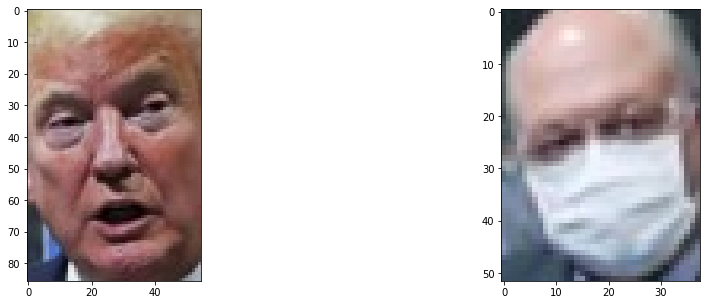

In [112]:
#dets에 저장된 값을 검사
#face로 추측되는 부분을 추출

faces = [] 

for i in range(dets.shape[2]): #여러개의 얼굴이 detect되었을 수도 있기 때문에 걸러냄
  confidence = dets[0, 0, i, 2] #정확성

  if confidence < 0.5: continue #정확성이 50% 미만이면 continue

  # if i < 200:
  x1 = int(dets[0, 0, i, 3] * w)
  y1 = int(dets[0, 0, i, 4] * h)
  
  x2 = int(dets[0, 0, i, 5] * w)
  y2 = int(dets[0, 0, i, 6] * h)
      
  face = img[y1:y2, x1:x2] #face 의 관심영역
  # else:
  #   x1 = int(dets[0, 0, i, 3] * wsyj)
  #   y1 = int(dets[0, 0, i, 4] * hsyj)
    
  #   x2 = int(dets[0, 0, i, 5] * wsyj)
  #   y2 = int(dets[0, 0, i, 6] * hsyj)

  #   face = imgSYJ[y1:y2, x1:x2] #face 의 관심영역

  faces.append(face)

plt.figure(figsize = (16, 5))

for n, face in enumerate(faces): #detect 된 face들을 출력
  plt.subplot(1, len(faces), n + 1)
  plt.imshow(face[:, :, ::-1])

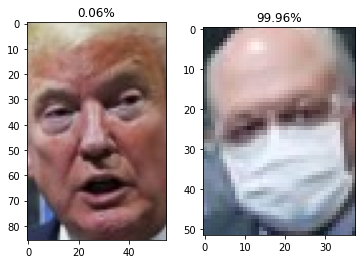

In [114]:
#Detect Masks from Faces
#추출된 face들중 마스크를 썼는지 안썼는지 Detect

#마스크를 썼는지 전처리

for i, face in enumerate(faces):
  face_input = cv2.resize(face, dsize = (224, 224)) #face를 resizing
  face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB) #RGB로 변경
  face_input = preprocess_input(face_input) #mobilenet_v2사용을 위한 전처리
  face_input = np.expand_dims(face_input, axis = 0) #mobilenet_v2는 (1, 224, 224, 3) 과 같이 되어야 하므로 dim 추가 ~> 원래는(224, 224, 3)이었음

  mask, nomask = model.predict(face_input).squeeze()

  plt.subplot(1, len(faces), i + 1)
  plt.imshow(face[:, :, ::-1])
  plt.title('%.2f%%'%(mask * 100))